In [1]:
import pandapower as pp
import pandapower.networks
import pandas as pd
import plotly.express as px
import numpy as np
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import os
os.sep = '/'
import time
seeds = [19,20,21,22,23]
seed = seeds[2]
np.random.seed(seed)
tf.random.set_seed(seed)

import matplotlib.pyplot as plt
%matplotlib inline
from pandapower.plotting.plotly import simple_plotly
from pandapower.plotting.plotly import vlevel_plotly
from pandapower.plotting.plotly import pf_res_plotly

from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl

In [2]:
net_full = pp.networks.mv_oberrhein()
net1, net2 = pp.networks.mv_oberrhein(separation_by_sub=True)

In [3]:
net = net1

In [ ]:
print(net.load.p_mw.sum())
print(net.sgen.p_mw.sum())

In [ ]:
import sys
sys.path.insert(0, './ReinforcementLearning')

from Agent import Agent
input_dim = 182
n_actions = 60*2
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/testing"

summary_writer = tf.summary.create_file_writer(log_dir)
rlagent1 = Agent(input_dim,n_actions=n_actions,scale_actions=1, fc1=128, fc2=64, batch_size=3,tensorboard_writer=None)#,alpha=0.001, beta=0.003, fc1=128, fc2=64
num_episodes = 2

In [ ]:
dummy_x = np.random.rand(input_dim)*0.1#**3000
dummy_x = tf.constant(dummy_x)
pred = rlagent1.choose_action(dummy_x)
plt.scatter(range(len(pred)),pred, s=3)

In [ ]:
tf.squeeze(dummy_x)

In [ ]:

for i in range(1000):
	rlagent.learn()

In [ ]:
pp.runpp(net)

In [ ]:
from pandapower.plotting.plotly import simple_plotly
from pandapower.plotting.plotly import vlevel_plotly
from pandapower.plotting.plotly import pf_res_plotly

fig = simple_plotly(net_full,aspectratio=(624,700),bus_size=8)
# # _ = vlevel_plotly(net)
# vm_pu = net.res_bus.vm_pu.drop(58)
# print('#',np.max(vm_pu))
# print('#',np.min(vm_pu))
# print('#',np.mean(vm_pu))
# print('#',np.std(vm_pu))
# fig = pf_res_plotly(net)
# 1.0509848460706623
# 1.0
# 1.0356294753271302
# 0.009557855595376996

# 1.0472164975218188
# 1.0
# 1.0320283534554817
# 0.009233739073123632

In [ ]:
def volatge_violation_function(vm_pus):
	violations = []
	a = 0.2
	m = 1
	tollerance = 0.05
	for vm in vm_pus:
		diff = 1-vm
		q = a*(tollerance**2) - m * tollerance
		if(np.abs(diff)<tollerance):
			v = a*(np.abs(diff)**2)
		elif(diff>0):
			v = m * diff + q
		else:
			v = -m * diff + q
		violations.append(v)
	return violations

di = 0.12
x = np.linspace(1-di/2,1+di/2,1000)
y = np.array(volatge_violation_function(x))

plt.figure(figsize=(10,6))
plt.plot(x,y)
plt.ylabel('Reward')
plt.xlabel('Voltage (p.u.)')

In [ ]:
volatge_violation_function([0.97,1.05])

In [ ]:
print('High Generation')
net, _ = pp.networks.mv_oberrhein("generation",separation_by_sub=True)
# print(net.load.loc[0])
# print(net.sgen.loc[0])
print(f"Total Load {net.load['p_mw'].sum():.2f} MW, scaling factor: {net.load['scaling'].iloc[0]}")
print(f"Total Generation {net.sgen['p_mw'].sum():.2f} MW, scaling factor: {net.sgen['scaling'].iloc[0]}")

print('\nHigh Load')
net,_ = pp.networks.mv_oberrhein("load",separation_by_sub=True)
# print(net.load.loc[0])
# print(net.sgen.loc[0])
print(f"Total Load {net.load['p_mw'].sum():.2f} MW, scaling factor: {net.load['scaling'].iloc[0]}")
print(f"Total Generation {net.sgen['p_mw'].sum():.2f} MW, scaling factor: {net.sgen['scaling'].iloc[0]}")

In [ ]:
#Plot network and loadings
from pandapower.plotting.plotly import simple_plotly
from pandapower.plotting.plotly import vlevel_plotly
from pandapower.plotting.plotly import pf_res_plotly

fig = simple_plotly(net, bus_size=6, ext_grid_size=5)
# _ = vlevel_plotly(net)
# fig = pf_res_plotly(net)
# fig.write_html(f"images/Gyn-anm network situation{case}.html")

In [ ]:
#Advanced plotting
import seaborn as sn
import pandapower.plotting as plot
import pandapower.topology as top

mg = top.create_nxgraph(net, nogobuses=set(net.trafo.lv_bus.values) | set(net.trafo.hv_bus.values))
colors = sn.color_palette()
collections = []

sizes = plot.get_collection_sizes(net)
for area, color in zip(top.connected_components(mg), colors):
	collections.append(plot.create_bus_collection(net, area, color=color, size=sizes["bus"]/2))
	line_ind = net.line.loc[:, "from_bus"].isin(area) | net.line.loc[:, "to_bus"].isin(area)
	lines = net.line.loc[line_ind].index
	collections.append(plot.create_line_collection(net, lines, color=color))
collections.append(plot.create_ext_grid_collection(net, size=sizes["ext_grid"]))
plot.draw_collections(collections)
plt.show()

In [ ]:
print(f'Number buses: {len(net.bus)}')
print(f'Number loads: {len(net.load)}')
print(f'Number sgens: {len(net.sgen)}')

In [ ]:
# a = [int(i.split(' ')[-1]) for i in net.bus['name']]
bus_indices = net.bus.index

c = {}
l = 0 
s = 0

nothing = 'rgb(0,0,0)'
only_load = 'rgb(255,0,0)'
only_res = 'rgb(0,255,0)'
both = 'rgb(0,100,255)'
net.bus['type'] = nothing #type: 0->nothing, 1->only load, 2->only res, 3->both
for i in bus_indices:
	c[i] = [0,0]
	if(i in list(net.load['bus']) and i in list(net.sgen['bus'])):
		net.bus['type'].loc[i] = both
	elif(i in list(net.load['bus'])):
		c[i][0]+=1
		l+=1
		net.bus['type'].loc[i] = only_load
	elif(i in list(net.sgen['bus'])):
		c[i][1]+=1
		s+=1
		net.bus['type'].loc[i] = only_res

	if(i in list(net.load['bus'])):
		c[i][0]+=1
		l+=1
	if(i in list(net.sgen['bus'])):
		c[i][1]+=1
		s+=1
print('{bus index, [load,gen]}')
print(c)

l = [[],[],[],[]]
for k,v in c.items():
	if(v[0]==0 and v[1]==0): #nothing
		l[0].append(k)
	if(v[0]>0 and v[1]==0): #only load
		l[1].append(k)
	if(v[0]==0 and v[1]>0): #only sgen
		l[2].append(k)
	if(v[0]>0 and v[1]>0): #both
		l[3].append(k)
print('\nNothing: ', l[0])
print('Only load: ', l[1])
print('Only sgen: ', l[2])
print('Both: ', l[3])
print(f'Ratio: Nothing/at least 1: {( len(l[0])/( len(l[0])+len(l[1])+len(l[2])+len(l[3]) ) ):.3f}')

In [ ]:
labels = {nothing: "Neither", only_load: 'Only Load', only_res: 'Only RES', both: 'Both'}
fig = simple_plotly(net, bus_size=5, ext_grid_size=10)
fig.update_layout(showlegend=False)
for i in net.bus.index:
	fig.add_trace(
			px.scatter(
				x=[net.bus_geodata.loc[i, 'x']],
				y=[net.bus_geodata.loc[i, 'y']],
				color=[net.bus.loc[i,'type']]).update_traces(marker=dict(color=net.bus.loc[i,'type'],
																		size=6)).data[0]
		)
fig.update_layout(showlegend=True,legend=dict(y=0.9), legend_title_text='', legend_font=dict(color='black'))

elems = set()
for i in range(len(fig.data)):
	if(fig.data[i].name in list(labels.keys()) and labels[fig.data[i].name] not in elems):
		fig.data[i].name = labels[fig.data[i].name]
		elems.add(fig.data[i].name)
	else:
		fig.data[i].showlegend=False
fig.show()


In [ ]:
# a = [int(i.split(' ')[-1]) for i in net.bus['name']]
bus_indices = net.bus.index

c = []
nc = []
l = 0
for i in net.load.to_numpy():
	if(i[1] in bus_indices):
		c.append(i[1])
		l+=1
	else:
		nc.append(i[1])
print(f'Loads connected to something: {c}')
print(f'Loads connected to nothing: {nc}')

print(f'\nLoads-> total: {len(net.load)}, connected to some bus: {l} (ratio: {(l/len(net.load)):.3f})')

In [ ]:
# a = [int(i.split(' ')[-1]) for i in net.bus['name']]
bus_indices = net.bus.index

c = []
nc = []
l = 0
for i in net.sgen.to_numpy():
	if(i[1] in bus_indices):
		c.append(i[1])
		l+=1
	else:
		nc.append(i[1])
print(f'Sgens connected to something: {c}')
print(f'Sgens connected to nothing: {nc}')

print(f'\nSgens-> total: {len(net.sgen)}, connected to some bus: {l} (ratio: {(l/len(net.sgen)):.3f})')

In [ ]:
print(net.load[net.load['scaling'] == 0].count())
print(net.sgen[net.sgen['scaling'] == 0].count()) #All sgen scaling value set to 0 since the default scenario is 'load'

In [12]:
active_reactive_ratio = net.load.p_mw.sum() / net.load.q_mvar.sum() #elementwise would be the same ratio

#All the scaling values are 0.6
net.sgen['scaling'] = 1
net.load['scaling'] = 1

def num_foreach_element(arr):
	d = {}
	for i in arr.to_numpy():
		i = i[0]
		d[i] = d[i]+1 if i in d.keys() else 1
	return dict(sorted(d.items()))
	
input_dir = './TimeSeries/1-MVLV-rural-all-0-sw/'
n_timesteps = 4 * 24 * 365

#Loads dataset
profile_load = pd.DataFrame()
n_load = len(net.load)
n_res = len(net.sgen)
# The parameter “sR” generally describes the nominal apparent power of power plants, distributed energy resources and loads
loads = pd.read_csv(f'{input_dir}Load.csv', sep=';')
loads_timeseries = pd.read_csv(f'{input_dir}LoadProfile.csv', sep=';')

RESs = pd.read_csv(f'{input_dir}RES.csv', sep=';')
RESs_timeseries = pd.read_csv(f'{input_dir}RESProfile.csv', sep=';')

#Cases:
# 0: low load, high generation
# 1: normal load and generation
# 2: high load, low generation
#How to choose them?
# - https://dl.acm.org/doi/pdf/10.1145/3488904.3493385 The author porposes a total power demand between 30/40 MW
case = 'rl'
if(case=='reference'):
	scale_factor_load = 0.8
	scale_factor_sgen = 1.2
	generate = True
elif(case=='rl'):
	scale_factor_load = 0.8
	scale_factor_sgen = 1.2
	generate = False
print(f'Case: {case}, scale load: {scale_factor_load}, scale sgen: {scale_factor_sgen}')
'''
# Papers:
# SimBench—A Benchmark Dataset of Electric Power Systems to Compare Innovative Solutions Based on Power Flow Analysis
# https://www.researchgate.net/profile/Christian-Spalthoff-2/publication/333903713_SimBench_Open_source_time_series_of_power_load_storage_and_generation_for_the_simulation_of_electrical_distribution_grids/links/5d889953458515cbd1b50cef/SimBench-Open-source-time-series-of-power-load-storage-and-generation-for-the-simulation-of-electrical-distribution-grids.pdf?origin=publication_detail
# https://publica.fraunhofer.de/eprints/urn_nbn_de_0011-n-5554297.pdf
Germany standard load profiles(SLPs): Commercial enterprises (G), households (H), agricultural holdings (L) and industrial companies
(BL/BW) were considered as accumulated consumers, while the provided time series for electric
vehicles (EVs) and heat pumps (HPs) were interpreted as individual consumers.
Ending letter: A-C low consumption, M medium, H high
#print(set(loads_timeseries.columns)) 
'''
# net.controller = pd.DataFrame() #Reset controllers
# index_to_select = range(n_load) #np.random.randint(0,len(loads),size=n_load)
# load_to_add = pd.DataFrame(['G3-M','G4-M','H0-H','G0-M','G3-M','G4-M'], columns=['profile'])
loads = loads.drop(loads[[ i in ['H0-G', 'H0-L'] for i in loads.profile]].index)
different_loads = list(set(loads.profile))
load_to_add = different_loads * int(n_load/len(different_loads)) + [ different_loads[i] for i in np.random.randint(0,len(different_loads),size=n_load-len(different_loads) * int(n_load/len(different_loads)))]
# index_to_select = np.random.randint(0,len(loads),size=n_load)
# index_to_select = np.random.randint(0,len(loads),size=n_load)

if(generate):
	loads_type = pd.DataFrame(load_to_add)
	temp_profile_p = []
	temp_profile_q = []
	print(f'Chosen load elements by type: {num_foreach_element(loads_type)}')
	for l in loads_type.to_numpy():
		val = 0.15
		noise = np.random.uniform(1-val,1+val,len(loads_timeseries)) #random noise in range [1-val,1+val[ -> change timeseries values by +/-val%
		temp_profile_p.append( loads_timeseries[f'{l[0]}_pload'] * noise)
		temp_profile_q.append( loads_timeseries[f'{l[0]}_qload'] * noise)

	#Loads p (in MW) 
	profile_load_p = pd.concat(temp_profile_p,axis=1)[:n_timesteps]
	#Loads q (in MVar)
	# profile_load_q = pd.concat(temp_profile_q,axis=1)[:n_timesteps]
	profile_load_q = profile_load_p.copy() / active_reactive_ratio
else:
	profile_load_p = pd.read_csv(input_dir+"/Results/reference/noscale_loads_p.csv")
	profile_load_p = profile_load_p.drop('Unnamed: 0',axis=1)

	profile_load_q = pd.read_csv(input_dir+"/Results/reference/noscale_loads_q.csv")
	profile_load_q = profile_load_q.drop('Unnamed: 0',axis=1)

profile_load_p.columns = net.load.index
ds_lp = DFData(profile_load_p)
cc_lp = ConstControl(net, 'load', 'p_mw', element_index=net.load.index, profile_name=profile_load_p.columns,
					data_source=ds_lp, scale_factor=scale_factor_load)

profile_load_q.columns = net.load.index
ds_lq = DFData(profile_load_q)
cc_lq = ConstControl(net, 'load', 'q_mvar', element_index=net.load.index, profile_name=profile_load_q.columns,
					data_source=ds_lq, scale_factor=scale_factor_load)

#RES p (in MW)
RESs = RESs.drop(RESs[[ i in ['BM1', 'BM2', 'BM3', 'Hydro2', 'PV8'] for i in RESs.profile]].index)
different_res = list(set(RESs.profile))
res_to_add = different_res * int(n_res/len(different_res)) + [ different_res[i] for i in np.random.randint(0,len(different_res),size=n_res-len(different_res) * int(n_res/len(different_res)))]
RESs_type = pd.DataFrame(res_to_add)
# res_to_add = pd.DataFrame(['WP4','WP4','WP4','WP7','WP7','WP7'], columns=['profile'])
# index_to_select = np.random.randint(0,len(RESs),size=n_res-len(res_to_add))
# RESs_type = RESs.loc[index_to_select,['profile']]
# RESs_type = pd.concat([RESs_type, res_to_add])
if(generate):
	temp_profile_p = []
	print(f'RES elements by type: {num_foreach_element(RESs_type)}')
	for l in RESs_type.to_numpy():
		val = .15
		noise = np.random.uniform(1-val,1+val,len(loads_timeseries)) #random noise in range [1-val,1+val[ -> change timeseries values by +/-val%
		temp_profile_p.append(RESs_timeseries[f'{l[0]}']*noise)
		# temp_profile_p.append(RESs_timeseries[f'{l[0]}_pload']) #Q values are not required
	profile_res_p = pd.concat(temp_profile_p,axis=1)[:n_timesteps]
else:
	profile_res_p = pd.read_csv(input_dir+"/Results/reference/noscale_RESs_p.csv")
	profile_res_p = profile_res_p.drop('Unnamed: 0',axis=1)
profile_res_p.columns = net.sgen.index
net.sgen.sn_mva = np.max(profile_res_p,axis=0)
ds_sp = DFData(profile_res_p)
cc_sp = ConstControl(net, 'sgen', 'p_mw', element_index=net.sgen.index, profile_name=profile_res_p.columns,
					data_source=ds_sp, scale_factor=scale_factor_sgen)

# profile_res_p = pd.read_csv(input_dir+"/Results/reference/noscale_RESs_p.csv")
# profile_res_p = profile_res_p.drop('Unnamed: 0',axis=1)
profile_res_q = profile_res_p.copy()
profile_res_q[:] = 0#(np.random.rand(35040,60) - 1) / 8
# profile_res_q[:] = np.sqrt(np.max(profile_res_p,axis=0)**2 - profile_res_q**2)
profile_res_q.columns = net.sgen.index
ds_sq = DFData(profile_res_q)
cc_sq = ConstControl(net, 'sgen', 'q_mvar', element_index=net.sgen.index, profile_name=profile_res_q.columns,
					data_source=ds_sq, scale_factor=1)

figsize=(22, 5)

Case: rl, scale load: 0.8, scale sgen: 1.2


In [ ]:
fig = plt.figure(figsize=figsize)
(cc_sp.data_source.df*cc_sp.scale_factor).sum(axis=1).plot(label='RES active power')
(cc_lp.data_source.df*cc_lp.scale_factor).sum(axis=1).plot(label='Load active power',ylabel='MW')
# (cc_lq.data_source.df*cc_lq.scale_factor).sum(axis=1).plot(label='Load reactive power',ylabel='MVAR')
# (cc_sq.data_source.df).sum(axis=1).plot(label='sgen q',ylabel='mw')
# profile_res_p.loc[:,['PV5', 'PV8', 'PV6']].sum(axis=1).plot(label='sgen PV')
# profile_res_p.loc[:,['WP4','WP7']].sum(axis=1).plot(label='sgen WP')
# w = 4 * 24 * 7
# (cc_lp.data_source.df*cc_lp.scale_factor).sum(axis=1).rolling(window = w).mean().plot(label='load p',ylabel='mw')
# (cc_sp.data_source.df*cc_sp.scale_factor).sum(axis=1).rolling(window = w).mean().plot(label='sgen')

ticks = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# ticks = range(1,91)

x = np.linspace(0,n_timesteps*(len(ticks)-1)/len(ticks), num=len(ticks))

plt.xticks(x, ticks, rotation=45)
plt.legend()
# plt.xlabel('time')
plt.title('Total load and generation')
plt.show()

###
#Similar energy consumption over the different months
#https://www.eia.gov/totalenergy/data/monthly/
#https://www.eia.gov/totalenergy/data/monthly/pdf/sec1.pdf
print(np.max((cc_sp.data_source.df*cc_sp.scale_factor).sum(axis=1)))
print(np.max((cc_lp.data_source.df*cc_lp.scale_factor).sum(axis=1)))

In [17]:
(cc_lq.data_source.df).sum().sum()

122155.82563234871

In [ ]:
for i in range(len(profile_res_p.columns)):
	plt.plot(profile_res_p.iloc[:,i], label=i)
	plt.show()

In [ ]:
RESs_timeseries.drop(['time','BM1', 'BM2', 'BM3', 'Hydro2'], axis=1).plot(figsize=(20,8))

In [ ]:
only_p = [i for i in loads_timeseries.columns if i.find('p')>=0]
for i in only_p:
	loads_timeseries[i].plot(figsize=(20,8))
	plt.title(i)
	plt.show()

Text(0, 0.5, 'MW')

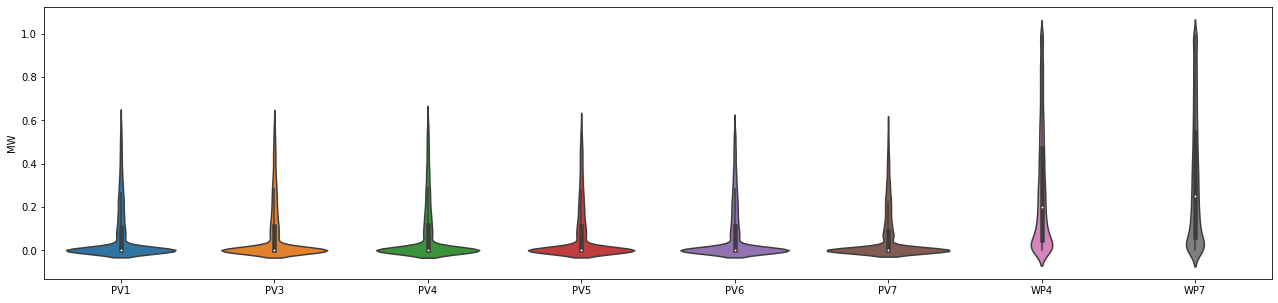

In [8]:
df = RESs_timeseries.drop(['BM1', 'BM2', 'BM3', 'Hydro2', 'PV8'],axis=1)
df =  df.loc[:,~df.columns.duplicated()]
# df.boxplot(rot=45,figsize=figsize)
plt.figure(figsize=figsize)
ax = sns.violinplot(data=df,figsize=figsize)
plt.ylabel('MW')
# plt.xlabel('profile')

Text(0, 0.5, 'MW')

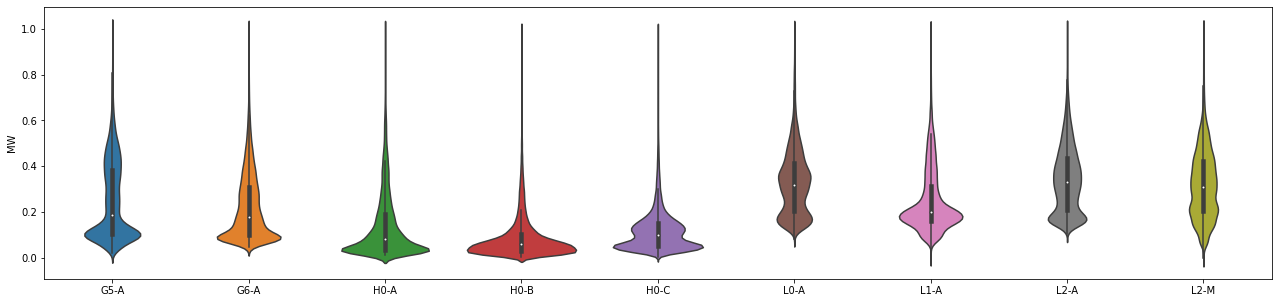

In [11]:
only_p = [i for i in loads_timeseries.columns if i.find('p')>=0]
# for i in only_p:
# 	loads_timeseries[i].plot(figsize=(20,8))
# 	plt.title(i)
# 	plt.show()

import seaborn as sns

only_p.remove('H0-G_pload')
only_p.remove('H0-L_pload')
df =  loads_timeseries.loc[:,only_p[10:]]
df.columns = [i[:4] for i in df.columns]
# df.boxplot(rot=0,figsize=figsize)

plt.figure(figsize=figsize)
ax = sns.violinplot(data=df,figsize=figsize)
plt.ylabel('MW')

In [ ]:
import datetime
# !rm -r logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

summary_writer = None #tf.summary.create_file_writer(log_dir)

In [ ]:
import sys
sys.path.insert(0, './ReinforcementLearning')

from Agent import Agent
input_dim = n_load*2+n_res
n_actions = 2*n_res
# n_actions = n_res
rlagent = Agent(input_dim,n_actions=n_actions,scale_actions=1, fc1=256, fc2=128,
	batch_size=64,alpha=0.0001, beta=0.001, tau=0.001, tensorboard_writer=summary_writer)#,alpha=0.001, beta=0.003, fc1=128, fc2=64
num_episodes = 2


In [ ]:
vm_pu_file = f'./TimeSeries/1-MVLV-rural-all-0-sw/Results/reference/res_bus/vm_pu.csv'
vm_pu = pd.read_csv(vm_pu_file, index_col=0, sep=';')
vm_pu_before = vm_pu.drop(columns='58' ) #External grid
#Classification sources:
# - https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
#Naive version
def classification_dataset(df):
	labels = []
	ln = []
	a = 0
	n=0
	acceptance_range = 0.1
	for i in df.to_numpy():
		if(np.any(i>1+acceptance_range/2) or np.any(i<1-acceptance_range/2)):# 
			labels.append(1)
			a+=1
		else:
			labels.append(0)
		if(np.any(i<1-acceptance_range/2)):#
			ln.append(1)
			n+=1
		else:
			ln.append(0)
	print(f'Number of critical situations: {a}, over {len(df)} time steps, ratio: {(a/len(df)*100):.1f}%')
	print(f'Number of critical situations(underv): {n}, over {len(ln)} time steps, ratio: {(n/len(ln)*100):.1f}%')
	return pd.DataFrame(labels,columns=['Label'])

#Less naive
# def f(window):
# 	return max(window)
# vm_pu['132'].rolling(3).apply(f)

vm_pu_classification = classification_dataset(vm_pu_before)

# Number of critical situations: 957, over 21024 time steps, ratio: 4.6%
# Number of critical situations(underv): 138, over 21024 time steps, ratio: 0.7%
# Number of critical situations: 828, over 21024 time steps, ratio: 3.9%
# Number of critical situations(underv): 143, over 21024 time steps, ratio: 0.7%

In [ ]:
a = []
for i,j in enumerate(vm_pu_classification.to_numpy()):
	if(j==1):
		a.append(i)

In [ ]:
a[90:100]

In [ ]:
ind = 2320
print('#',(cc_sp.data_source.df*cc_sp.scale_factor).sum(axis=1)[ind])
print('#',(cc_lp.data_source.df*cc_lp.scale_factor).sum(axis=1)[ind])
print('#',(cc_lq.data_source.df*cc_lq.scale_factor).sum(axis=1)[ind])
# 16.59774311108169
# 8.443675805530273
# 1.71456149989872


# 17.446612772221627
# 8.674299694501384
# 1.7613916779034013

In [ ]:
vm_pu_before.loc[ind].plot()

In [ ]:
rl = True
train = False #RUN CELL ABOVE
output_dir = os.path.join(input_dir,"Results", str(case))
if(rl):
	split = 0.4
	if(train):
		time_steps = range(0,int(n_timesteps * split))
		num_episodes = 4
		print(f'Training on {len(time_steps)} elements for {num_episodes} episodes')

		if(True):
			mean_load_p = (cc_lp.data_source.df[:len(time_steps)]*cc_lp.scale_factor).mean(axis=0)
			std_load_p = (cc_lp.data_source.df[:len(time_steps)]*cc_lp.scale_factor).std(axis=0)
			mean_load_q = (cc_lq.data_source.df[:len(time_steps)]*cc_lq.scale_factor).mean(axis=0)
			std_load_q = (cc_lq.data_source.df[:len(time_steps)]*cc_lq.scale_factor).std(axis=0)
			mean_sgen_p = (cc_sp.data_source.df[:len(time_steps)]*cc_sp.scale_factor).mean(axis=0)
			std_sgen_p = (cc_sp.data_source.df[:len(time_steps)]*cc_sp.scale_factor).std(axis=0)
			means = np.transpose(np.concatenate([mean_load_p,mean_load_q,mean_sgen_p], axis=0))
			stds = np.transpose(np.concatenate([std_load_p,std_load_q,std_sgen_p], axis=0))
			rlagent.set_means_stds(means,stds)
	else:
		time_steps = range(int(n_timesteps * split),n_timesteps)
		num_episodes = 1
		output_dir+='/Testing'
		print(f'Testing on {len(time_steps)} elements')
else:
		time_steps = range(0,n_timesteps)
		num_episodes = 1


ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".csv", log_variables=list())

#Save time series (output)
# these variables are saved to the harddisk after / during the time series loop
ow.log_variable('res_load', 'p_mw')
ow.log_variable('res_load', 'q_mvar')
ow.log_variable('res_bus', 'vm_pu')
ow.log_variable('res_bus', 'p_mw')
ow.log_variable('res_bus', 'q_mvar')
# ow.log_variable('res_bus', 'va_degree')
ow.log_variable('res_line', 'loading_percent')
# ow.log_variable('res_line', 'i_ka')
ow.log_variable('res_ext_grid', 'p_mw')
ow.log_variable('res_ext_grid', 'q_mvar')

t_start = time.time()
print('Time steps: ',len(time_steps), '. Num Loads: ', net.load.index.shape, '. Load p and q: ', profile_load_p.shape, profile_load_q.shape, '. Num RESs: ', net.sgen.index.shape, '. RESs p: ',profile_res_p.shape)
for i in range(num_episodes):
	t1 = time.time()
	if (i == num_episodes - 1):
		save = True
	else:
		save = False
	
	if(rl):
		for_rl = {'agent': rlagent, 'save': save, 'train':train,
			'vm_pu_labels': np.squeeze(np.array(vm_pu_classification))} #np.squeeze(np.array(vm_pu_classification))
		run_timeseries(net,time_steps, for_rl)
		t2 = time.time()
		print(f'Run {i+1}/{num_episodes}, time : {(t2-t1):.2f} s ({((t2-t1)/60):.1f} m)')

		history = rlagent.history
		ps = []
		qs = []
		vv1s = []
		vv2s = []
		rs = []
		for p,q,vv1,vv2,r in history:
			ps.append(p)
			qs.append(q)
			vv1s.append(vv1)
			vv2s.append(vv2)
			rs.append(r)
		# plt.scatter(range(len(rlagent.history)),rlagent.history,s=1)
		# losses = pd.DataFrame(rlagent.history)
		# losses.rolling(4*24).mean().plot()
		s = 1.5
		plt.scatter(range(len(ps)),np.array(ps),s=s, label='p')
		plt.scatter(range(len(qs)),np.array(qs),s=s, label='q')
		plt.scatter(range(len(vv1s)),np.array(vv1s),s=s, label='vv1')
		plt.scatter(range(len(vv2s)),np.array(vv2s),s=s, label='vv2')
		plt.scatter(range(len(rs)),rs,s=s, label='r')
		plt.legend()
		# plt.ylim([-500,500])
		plt.show()
	else:
		run_timeseries(net,time_steps)
t_end = time.time()
print(f'Total Simulation time : {(t_end-t_start):.2f} s ({((t_end-t_start)/60):.1f} m)')

#Save time series (input)
if(rl is False):
	path = os.path.join(output_dir, "loads_p.csv")
	(cc_lp.data_source.df*cc_lp.scale_factor).to_csv(path)
	path = os.path.join(output_dir, "loads_q.csv")
	(cc_lq.data_source.df*cc_lq.scale_factor).to_csv(path)
	path = os.path.join(output_dir, "RESs_p.csv")
	(cc_sp.data_source.df*cc_sp.scale_factor).to_csv(path)

	path = os.path.join(output_dir, "noscale_loads_p.csv")
	(cc_lp.data_source.df).to_csv(path)
	path = os.path.join(output_dir, "noscale_loads_q.csv")
	(cc_lq.data_source.df).to_csv(path)
	path = os.path.join(output_dir, "noscale_RESs_p.csv")
	(cc_sp.data_source.df).to_csv(path)
	t3 = time.time()
	print(f'Saving files time: {(t3-t_end):.2f} s')

#Total Simulation time : 521.57 s (8.7 m)
#Total Simulation time : 1775.19 s (29.6 m)
# print(rlagent.noise)

In [ ]:
# history = rlagent.history
# ps = []
# qs = []
# vv1s = []
# vv2s = []
# rs = []
# for p,q,vv1,vv2,r in history:
# 	ps.append(p)
# 	qs.append(q)
# 	vv1s.append(vv1)
# 	vv2s.append(vv2)
# 	rs.append(r)
# # plt.scatter(range(len(rlagent.history)),rlagent.history,s=1)
# # losses = pd.DataFrame(rlagent.history)
# # losses.rolling(4*24).mean().plot()
# s = 1.5
# plt.scatter(range(len(ps)),np.array(ps),s=s, label='p')
# plt.scatter(range(len(qs)),np.array(qs),s=s, label='q')
# plt.scatter(range(len(vv1s)),np.array(vv1s),s=s, label='vv1')
# plt.scatter(range(len(vv2s)),np.array(vv2s),s=s, label='vv2')

# plt.scatter(range(len(ps)),np.array(ps)/alpha_p,s=s, label='p')
# plt.scatter(range(len(qs)),np.array(qs)/alpha_q,s=s, label='q')
# plt.scatter(range(len(vv1s)),np.array(vv1s)/beta,s=s, label='vv1')
# plt.scatter(range(len(vv2s)),np.array(vv2s)/gamma,s=s, label='vv2')
# plt.scatter(range(len(rs)),rs,s=s, label='r')
# plt.legend()
# # plt.ylim([-60,1])
# plt.show()

# figsize=(10, 5)
losses = pd.DataFrame(rs)
# plt.plot(rs)
fig = plt.figure(figsize=figsize)
# plt.scatter(range(len(rs)),np.array(rs),s=s,c='r')
_ = plt.plot(losses.rolling(4*24*2).mean())
# plt.ylim([-50,6])
plt.ylabel('Total reward')
plt.xlabel('Step')
# plt.show()

In [ ]:
history = rlagent.history_noscale
ps = []
qs = []
vv1s = []
vv2s = []
rs = []
for p,q,vv1,vv2,r in history:
	ps.append(p)
	qs.append(q)
	vv1s.append(vv1)
	vv2s.append(vv2)
	rs.append(r)
# plt.scatter(range(len(rlagent.history)),rlagent.history,s=1)
# losses = pd.DataFrame(rlagent.history)
# losses.rolling(4*24).mean().plot()
s = 1.5
plt.scatter(range(len(ps)),-np.array(ps),s=s, label='p')
plt.scatter(range(len(qs)),-np.array(qs),s=s, label='q')
plt.scatter(range(len(vv1s)),-np.array(vv1s),s=s, label='vv1')
plt.scatter(range(len(vv2s)),np.array(vv2s),s=s, label='vv2')
plt.legend()

In [ ]:
history = rlagent.history_test
ps = []
qs = []
vv1s = []
vv2s = []
rs = []
for p,q,vv1,vv2,r in history:
	ps.append(p)
	qs.append(q)
	vv1s.append(vv1)
	vv2s.append(vv2)
	rs.append(r)
s = 1.5
plt.scatter(range(len(vv2s)),np.array(vv2s),s=s, label='vv2')
plt.scatter(range(len(ps)),np.array(ps),s=s, label='p')
plt.scatter(range(len(qs)),np.array(qs),s=s, label='q')
plt.scatter(range(len(vv1s)),np.array(vv1s),s=s, label='vv1')
plt.scatter(range(len(rs)),np.array(rs),s=s, label='total r')
plt.legend()

losses = pd.DataFrame(rs)
losses.rolling(4*120).mean().plot()
# plt.ylim([-60,20])
plt.show()

In [ ]:
q_values = [i[0] for i in rlagent.q_values]
# q_values_tar = [i[1] for i in rlagent.q_values]
# q_values_tar1 = [i[2] for i in rlagent.q_values]
plt.scatter(range(len(q_values)),np.array(q_values),s=s, label='q values')
# plt.scatter(range(len(q_values_tar)),np.array(q_values_tar),s=s, label='q values_tar')
# plt.scatter(range(len(q_values_tar1)),np.array(q_values_tar1),s=s, label='q values_tar1')

In [ ]:
noises = rlagent.noises
plt.scatter(range(len(noises)),np.array(noises),s=s, label='noise evolution')

In [ ]:
critic_loss = [ i[0] for i in rlagent.losses]
actor_loss = [ i[1] for i in rlagent.losses]

plt.scatter(range(len(critic_loss)), critic_loss, s=s, label='critic loss')
plt.scatter(range(len(actor_loss)), actor_loss, s=s, label='actor loss')
plt.ylim([-1,500])
plt.legend()
plt.show()

# losses.rolling(4*240).mean().plot()
# plt.ylim([-30,10])
# plt.show()

In [ ]:
perc = []
mw_curt = []
mw_tot = []
q_tot = []
q_tot_abs = []
for p,v,t,q,qa in rlagent.curtailment:
	perc.append(p)
	mw_curt.append(v)
	mw_tot.append(t)
	q_tot.append(q)
	q_tot_abs.append(qa)
perc = perc[-int(n_timesteps * (1-split)):]
mw_curt = mw_curt[-int(n_timesteps * (1-split)):]
mw_tot = mw_tot[-int(n_timesteps * (1-split)):]
q_tot = q_tot[-int(n_timesteps * (1-split)):]
q_tot_abs = q_tot_abs[-int(n_timesteps * (1-split)):]
print(len(rlagent.curtailment))
print(int(len(perc)))

In [ ]:
plt.scatter(range(len(perc)),perc,s=1)

In [ ]:
plt.scatter(range(len(mw_curt)),mw_curt,s=1)

In [ ]:
plt.scatter(range(len(q_tot)),q_tot,s=1)

In [ ]:
plt.scatter(range(len(q_tot_abs)),q_tot_abs,s=1)

In [ ]:
# dummy_x = [0]*input_dim
dummy_x = np.random.rand(input_dim)#**3000
# dummy_x = tf.concat([net.load.p_mw,net.load.q_mvar,net.sgen.p_mw],0)
print(np.min(dummy_x))
print(np.max(dummy_x))
print(np.mean(dummy_x))
print(np.std(dummy_x),'\n')
pred = rlagent.choose_action(dummy_x)
print(np.min(pred))
print(np.max(pred))
print(np.mean(pred))
print(np.std(pred), '\n')
plt.scatter(range(len(pred)),pred, s=3)

# print(pred)
indx = np.where(pred == 1)[0] #25, 37
print(indx)
# print(net.sgen.index)
# print(net.sgen.index[indx])


In [ ]:
plt.scatter(range(len(rlagent.p_for_gen)),rlagent.p_for_gen, s=s)
# plt.scatter(range(len(rlagent.q_for_gen)),rlagent.q_for_gen, s=s)

np.argmax(rlagent.p_for_gen)

In [ ]:
net.sgen.iloc[31]

In [ ]:
for i in indx:
	fig = cc_sp.data_source.df[net.sgen.index[i]].plot()
	fig.plot()
	plt.plot()
	l = 0.0000001
	plt.ylim([-l,l])

In [ ]:
print(f'Total energy {np.sum(mw_tot):.0f} MW, total energy curtailment: {np.sum(mw_curt):.3f} MW in {len(mw_curt)} timesteps(~{int(len(mw_curt)/(4*24*365)*12)} months), ratio: {(np.sum(mw_curt)/np.sum(mw_tot)*100):.2f}% \naverage for 15mins: {(np.mean(mw_curt)):.2f}+/-{np.std(mw_curt):.2f} MW, average for 15mins per RES device: {(np.mean(mw_curt)/n_res*1000):.2f} kW')
print(f'\n{np.sum(q_tot):.5f} {np.max(q_tot):.5f} {np.min(q_tot):.5f} {np.mean(q_tot):.5f} {np.std(q_tot):.5f}')
print(f'\n{np.sum(q_tot_abs):.5f} {np.max(q_tot_abs):.5f} {np.min(q_tot_abs):.5f} {np.mean(q_tot_abs):.5f} {np.std(q_tot_abs):.5f}')
# print(len(perc))
# print(np.sum(val)/len(val))

In [ ]:
#Save run
rew = pd.DataFrame(rs)
rew.columns = ['reward']
rew.to_csv(f'{input_dir}/Results/Control runs/rew_run{seed}',index=False)

file = open(f'{input_dir}/Results/Control runs/curt_run{seed}', 'w')
file.write(f'{np.sum(mw_curt)},{np.sum(q_tot_abs)}')
file.close()

In [ ]:
#Load runs

rewards = pd.DataFrame([])
for i in seeds[:3]:
	r = pd.read_csv(f'{input_dir}/Results/Control runs/rew_run{i}')
	rewards[i] = r

window = 4 * 24
mean_rewards = np.mean(rewards,axis=1).rolling(window).mean()
std_rewards = np.std(rewards,axis=1).rolling(window).mean()

fig, ax = plt.subplots(figsize=figsize)
ax.set_xlabel('Step')
ax.plot(range(len(mean_rewards)),mean_rewards, markersize=1, marker="o")
ax.fill_between(range(len(std_rewards)), mean_rewards-2*std_rewards, mean_rewards+2*std_rewards, alpha=0.4)
# ax.legend(loc='upper left')
ax.set_ylabel('Total reward')
plt.show()


In [ ]:
case_1 = []
case_2 = []
case_3 = []
case_4 = []
case_1_q = []
case_2_q = []
case_3_q = []
case_4_q = []
a = 0
for i in range(len(vm_pu_classification_a)):
	if(i<len(vm_pu_classification_a)-1):
		problem_before = vm_pu_classification_b.loc[i+1][0]
		problem_after = vm_pu_classification_a.loc[i+1][0]
		if(problem_before==0 and problem_after==0):
			case_1.append([perc[i],mw_curt[i]])
			case_1_q.append(q_tot_abs[i])
		elif(problem_before==1 and problem_after==0):
			case_2.append([perc[i],mw_curt[i]])
			case_2_q.append(q_tot_abs[i])
		elif(problem_before==1 and problem_after==1):
			case_3.append([perc[i],mw_curt[i]])
			case_3_q.append(q_tot_abs[i])
		elif(problem_before==0 and problem_after==1):
			case_4.append([perc[i],mw_curt[i]])
			case_4_q.append(q_tot_abs[i])
		# else:
		# 	curt_not_needed.append([perc[i],mw_curt[i]])

		
print(f'#Curtailment needed (case2): {(np.sum([i[1] for i in case_2])):.2f}')
print(f'#Not needed:\n#case 1(0-0): {(np.sum([i[1] for i in case_1])):.2f}')
print(f'#case 3(1-1): {(np.sum([i[1] for i in case_3])):.2f}')
print(f'#case 4(0-1): {(np.sum([i[1] for i in case_4])):.2f}')
print('\nFor q:')
print(f'#q needed (case2): {(np.sum([i for i in case_2_q])):.2f}')
print(f'#Not needed:\n#case 1(0-0): {(np.sum([i for i in case_1_q])):.2f}')
print(f'#case 3(1-1): {(np.sum([i for i in case_3_q])):.2f}')
print(f'#case 4(0-1): {(np.sum([i for i in case_4_q])):.2f}')


In [ ]:
dp = pd.DataFrame(rlagent.history_actions)[-int(n_timesteps * (1-split)):].reset_index(drop=True)
gen = ((cc_sp.data_source.df*cc_sp.scale_factor)[-int(n_timesteps * (1-split)):]).reset_index(drop=True)
load = ((cc_lp.data_source.df*cc_lp.scale_factor)[-int(n_timesteps * (1-split)):]).reset_index(drop=True)
dq = pd.DataFrame(rlagent.curtailment)[-int(n_timesteps * (1-split)):].reset_index(drop=True)

In [ ]:
# plt.figure(figsize=(20,7))
fig, ax1 = plt.subplots()
plt.scatter(range(len(vm_pu_classification_b)), vm_pu_classification_b*45, s=10)


fig.set_figwidth(20)
fig.set_figheight(7)
ax2 = ax1.twinx()
x = range(len(dp))
ax1.plot(x, gen.sum(axis=1), color='b')
ax2.plot(x, np.sum(np.array(gen)*(np.array(dp)), axis=1) , color='b')
ax2.plot(x, dq[3] , color='g')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')
# ax2.set_ylim([12.5,15])
# ax2.tick_params(axis='y')
fig.tight_layout()
plt.legend()
plt.show()# plt.figure(figsize=(20,7))
fig, ax1 = plt.subplots()
plt.scatter(range(len(vm_pu_classification_b)), vm_pu_classification_b*45, s=10)


fig.set_figwidth(20)
fig.set_figheight(7)
ax2 = ax1.twinx()
x = range(len(dp))
ax1.plot(x, gen.sum(axis=1), color='b')
ax2.plot(x, np.sum(np.array(gen)*(np.array(dp)), axis=1) , color='b')
ax2.plot(x, dq[3] , color='g')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')
# ax2.set_ylim([12.5,15])
# ax2.tick_params(axis='y')
fig.tight_layout()
plt.legend()
plt.show()

In [ ]:
width = 1000
fig = px.line(cc_lp.data_source.df*cc_lp.scale_factor,x=time_steps, y=profile_load_p.columns, width=width, height=400)
fig.show()
fig = px.line(cc_lq.data_source.df*cc_lq.scale_factor,x=time_steps, y=profile_load_q.columns, width=width, height=400)
fig.show()
fig = px.line(cc_sp.data_source.df*cc_sp.scale_factor,x=time_steps, y=profile_res_p.columns, width=width, height=400)
fig.show()

In [ ]:
def plot_df(df,title='',x_axis='',y_axis='',file_name='', ticks=''):
	fig = px.line(df,x=time_steps, y=df.columns, width=1200, height=600)
	fig.update_layout(title=title,
					xaxis_title=x_axis,
					yaxis_title=y_axis)

	x = np.linspace(0,n_timesteps*(len(ticks)-1)/len(ticks), num=len(ticks))
	fig.update_xaxes(tickangle=-45,
					tickmode = 'array',
					tickvals = x,
					ticktext= list(ticks))
	if(file_name):
		fig.write_html(file_name)
		print(f'Saved \'{title}\' in \'{file_name}\'')
	# fig.show()

# output_dir = os.path.join(input_dir,"Results", str(case))
save = False
x_axis = ''

# voltage results
vm_pu_file = f'{output_dir}/res_bus/vm_pu.csv'
vm_pu = pd.read_csv(vm_pu_file, index_col=0, sep=';')
vm_pu = vm_pu.drop(columns='58' ) #External grid
if(save):
	plot_df(vm_pu,'buses voltage magnitude',x_axis, 'bus vm [pu]', os.path.join(output_dir, "Plots", "bus vm.html"), ticks=ticks)

# # line loading resulcsvts
ll_file = os.path.join(output_dir, "res_line", "loading_percent.csv")
line_loading = pd.read_csv(ll_file, index_col=0, sep=';')
if(save):
	plot_df(line_loading,'line_loading',x_axis, 'line_loading [%]', os.path.join(output_dir, "Plots", "line load.html"), ticks=ticks)

# # load results
load_file = os.path.join(output_dir, "res_load", "p_mw.csv")
load = pd.read_csv(load_file, index_col=0, sep=';')
if(save):
	plot_df(load,'load active power',x_axis, 'p [MW]', os.path.join(output_dir, "Plots", "load.html"), ticks=ticks)
load_file = os.path.join(output_dir, "res_load", "q_mvar.csv")
load_q = pd.read_csv(load_file, index_col=0, sep=';')

res_prepf = pd.read_csv(os.path.join(output_dir, "RESs_p.csv"))
res_prepf = res_prepf.drop('Unnamed: 0',axis=1)

In [ ]:
vm_pu_file = f'./TimeSeries/1-MVLV-rural-all-0-sw/Results/reference/res_bus/vm_pu.csv'
vm_pu = pd.read_csv(vm_pu_file, index_col=0, sep=';')
vm_pu_before = vm_pu.drop(columns='58' ) #External grid
print(len(vm_pu_before))
# vm_pu_before = vm_pu_before[-int(n_timesteps * (1-split)):]
print(len(vm_pu_before))

vm_pu_file = f'./TimeSeries/1-MVLV-rural-all-0-sw/Results/rl/Testing/res_bus/vm_pu.csv'
# vm_pu_file = f'./TimeSeries/1-MVLV-rural-all-0-sw/Results/rl/res_bus/vm_pu.csv'
vm_pu = pd.read_csv(vm_pu_file, index_col=0, sep=';')
vm_pu_after = vm_pu.drop(columns='58' ) #External grid
print(len(vm_pu_after))

In [ ]:
figsize=(22, 4)
fig = plt.figure(figsize=figsize)
(res_prepf).sum(axis=1).plot(label='load p',ylabel='mw')
(load).sum(axis=1).plot(label='sgen')

ticks = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# ticks = range(1,91)

x = np.linspace(0,n_timesteps*(len(ticks)-1)/len(ticks), num=len(ticks))

plt.xticks(x, ticks, rotation=45)
plt.legend()
# plt.xlabel('time')
plt.title('Total load and generation')
plt.show()


In [ ]:
vm_pu_before.plot(figsize=figsize)
vm_pu_after.plot(figsize=figsize)

In [ ]:
df = pd.DataFrame()
vm_pu = vm_pu_before
# vm_pu = vm_pu_after
df['max'] = vm_pu.max(axis=1)
df['min'] = vm_pu.min(axis=1)
ch = []
cl = []

for index, row in df.iterrows():
	if(row['max']>1.05):
		ch.append('r')
	else:
		ch.append('b')
	if(row['min']<0.95):
		cl.append('r')
	else:
		cl.append('b')
		
df['over'] = ch
df['under'] = cl
# # d = {True: 'Voltage problem', False: 'Normal condition'}
# # df = df.replace(d)
# fig = px.scatter(df,x=df.index,y='max',color='over', width=1000, height=400)
# # fig.update_yaxes(type='category')
# fig.update_traces(marker_size=5)
# fig.update_layout(
# 	title="",
# 	xaxis_title="Time steps",
# 	yaxis_title="max bus vm [pu]",
# 	legend_title="")

In [ ]:
ticks = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# ticks = range(1,91)

x = np.linspace(0,n_timesteps*(len(ticks)-1)/len(ticks), num=len(ticks))

In [ ]:
fig = plt.figure(figsize=figsize)
s = 5
ma = plt.scatter(x=df.index,y=df['max'],c=df['over'],s=s, marker='^')
mi = plt.scatter(x=df.index,y=df['min'],c=df['under'],s=s, marker='v')

plt.scatter(x=[],y=[],c=['r'], marker='^', s=s, label='Maxs overvoltages')
plt.scatter(x=[],y=[],c=['b'], marker='^', s=s, label='Maxs normal')
plt.scatter(x=[],y=[],c=['r'], marker='v', s=s, label='Mins undervoltages')
plt.scatter(x=[],y=[],c=['b'], marker='v', s=s, label='Mins normal')

# plt.axvline(x=n_timesteps * 0.7)
# plt.axvline(x=n_timesteps * 0.9)
# plt.axhline(y=1.05)
# plt.axhline(y=0.95)
# plt.axhline(y=df['max'].mean())
plt.axhline(y=1.05)
plt.axhline(y=0.95)
print(df['max'].mean(), df['max'].max(), df['max'].min())
print(df['min'].mean(), df['min'].max(), df['min'].min())

# gp = (cc_sp.data_source.df*cc_sp.scale_factor).sum(axis=1)[-int(n_timesteps * (1-split)):]
# lp = (cc_lp.data_source.df*cc_lp.scale_factor).sum(axis=1)[-int(n_timesteps * (1-split)):]
# (lp/lp.max()*0.10+0.95).plot(label='load')
# (gp/gp.max()*0.10+0.95).plot(label='sgen')

# plt.xticks(x, ticks, rotation=45)
plt.legend(loc='lower right')
plt.ylabel('Voltage magnitude (p.u.)')
plt.xlabel('Step')
plt.show()

In [ ]:
#Plot network and loadings

bus = 58
fig = simple_plotly(net, bus_size=5, ext_grid_size=10)
fig.add_trace(px.scatter(x=[net.bus_geodata.loc[bus, 'x']], y=[net.bus_geodata.loc[bus, 'y']],color=['r'],size=[10]).data[0])
# _ = vlevel_plotly(net, bus_size=5, ext_grid_size=10)
# fig = pf_res_plotly(net, bus_size=8)
# fig.write_html(f"images/MVOberrhein/Half2.html")
# fig.write_image(f"images/MVOberrhein/Half2.png")

In [ ]:
print(vm_pu[58]) #constant voltage?
print(net.bus.loc[95])
print(net.load[net.load['bus']==58]) #no load in bus 58

In [ ]:
#Classification sources:
# - https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
#Naive version
def classification_dataset(df):
	labels = []
	ln = []
	a = 0
	n=0
	acceptance_range = 0.1
	for i in df.to_numpy():
		if(np.any(i>1+acceptance_range/2)):# or np.any(i<1-acceptance_range/2)
			labels.append(1)
			a+=1
		else:
			labels.append(0)
		if(np.any(i<1-acceptance_range/2)):#
			ln.append(1)
			n+=1
		else:
			ln.append(0)
	print(f'Number of critical situations: {a}, over {len(df)} time steps, ratio: {(a/len(df)*100):.2f}%')
	print(f'Number of critical situations(underv): {n}, over {len(ln)} time steps, ratio: {(n/len(ln)*100):.2f}%')
	return pd.DataFrame(labels,columns=['Label'])

#Less naive
# def f(window):
# 	return max(window)
# vm_pu['132'].rolling(3).apply(f)

vm_pu_classification = classification_dataset(vm_pu)
print()
vm_pu_classification_b = classification_dataset(vm_pu_before)
vm_pu_classification_a = classification_dataset(vm_pu_after)

# Number of critical situations: 957, over 21024 time steps, ratio: 4.6%
# Number of critical situations(underv): 138, over 21024 time steps, ratio: 0.7%
# Number of critical situations: 828, over 21024 time steps, ratio: 3.9%
# Number of critical situations(underv): 143, over 21024 time steps, ratio: 0.7%

In [ ]:
acceptance_range = 0.1
di_over = {}
di_under = {}
for item in vm_pu.to_numpy():
	for i,j in zip(net.bus.index,item):
		# print(i,j,item)
		if(np.any(j>1+acceptance_range/2)):# or np.any(i<1-acceptance_range/2)
			if(i in di_over.keys()):
				di_over[i]+=1
			else:
				di_over[i]=1
		if(np.any(j<1-acceptance_range/2)):#
			if(i in di_under.keys()):
				di_under[i]+=1
			else:
				di_under[i]=1

In [ ]:
x = pd.concat([vm_pu], axis=1)
# x = pd.concat([res_prepf], axis=1)
y = vm_pu_classification
deep_models = True

In [ ]:
rlagent.save_models()

In [ ]:
sum_load_p = load.sum(axis=1)
sum_load_q = load_q.sum(axis=1)
sum_res_p = res_prepf.sum(axis=1)

x = pd.concat([sum_load_p,sum_load_q,sum_res_p], axis=1)
y = vm_pu_classification
deep_models = False

In [ ]:
s,a,r,n,d = rlagent.memory.sample_experiences(2)
print(s.shape)
print(a.shape)
print(r.shape)
print(n.shape)
print(d.shape)

In [ ]:
#This is a simple transformation of the series into a new time series, which we use to remove the series dependence on time and stabilize the mean of the time series, so trend and seasonality are reduced during this transformation.
x = x.diff(axis = 0, periods = 1)
#Remove NAN values
x = x.drop(index=0,axis=1)
y = y.drop(index=0,axis=1)

In [ ]:
from pandas.core.common import standardize_mapping
# x.columns = [f'l_{name}' for name in x.columns]
# y.columns = [f'bvm_{name}' for name in y.columns]
df = pd.concat([x], axis=1)

n = len(df)


if(deep_models):
	#Maybe 0.65, 0.85 is better
	# train_portion = 0.8
	# val_portion = 0.9
	train_portion = 0.7
	val_portion = 0.9

	train_df = df[0:int(n*train_portion)]
	val_df = df[int(n*train_portion):int(n*val_portion)]
	test_df = df[int(n*val_portion):]

	train_df = pd.concat( [(train_df), y[0:int(n*train_portion)]], axis=1)
	val_df = pd.concat( [(val_df), y[int(n*train_portion):int(n*val_portion)]], axis=1)
	test_df = pd.concat( [(test_df), y[int(n*val_portion):]], axis=1)
	print(train_df.shape,val_df.shape,test_df.shape)
else:
	train_portion = 0.8
	train_df = df[0:int(n*train_portion)]
	test_df = df[int(n*train_portion):]

	train_mean = train_df.mean()
	train_std = train_df.std()

	train_df = pd.concat( [(train_df - train_mean) / train_std,y[0:int(n*train_portion)]], axis=1)
	test_df = pd.concat( [(test_df - train_mean) / train_std,y[int(n*train_portion):]], axis=1)
	print(train_df.shape,test_df.shape)

In [ ]:
if(deep_models):
	a = y[0:int(n*train_portion)]
	b = y[int(n*train_portion):int(n*val_portion)]
	c = y[int(n*val_portion):]
	# print(f'Total # of critical instants: {list(a.sum()+b.sum()+c.sum())[0]}, ratio: {(list((a.sum()+b.sum()+c.sum())/(a.count()+b.count()+c.count())*100)[0]):.1f}%')
	print(f'\State Number of critical instants in Train set: {list(a.sum())[0]}, ratio: {(list(a.sum()/a.count()*100)[0]):.1f}%')
	print(f'\State Number of critical instants in Val set: {list(b.sum())[0]}, ratio: {(list(b.sum()/b.count()*100)[0]):.1f}%')
	print(f'\State Number of critical instants in Test set: {list(c.sum())[0]}, ratio: {(list(c.sum()/c.count()*100)[0]):.1f}%')
else:
	a = y[0:int(n*train_portion)]
	c = y[int(n*train_portion):]
	# print(f'Total # of critical instants: {list(a.sum()+b.sum()+c.sum())[0]}, ratio: {(list((a.sum()+b.sum()+c.sum())/(a.count()+b.count()+c.count())*100)[0]):.1f}%')
	print(f'\State Number of critical instants in Train set: {list(a.sum())[0]}, ratio: {(list(a.sum()/a.count()*100)[0]):.1f}%')
	print(f'\State Number of critical instants in Test set: {list(c.sum())[0]}, ratio: {(list(c.sum()/c.count()*100)[0]):.1f}%')


In [ ]:
total = len(a)
pos = a.sum()
neg = total - pos

weight_for_0 = (1 / neg) * (total / 2)
weight_for_1 = (1 / pos) * (total / 2) / 8

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f'Weight for class 0: {weight_for_0:.2f}')
print(f'Weight for class 1: {weight_for_1:.2f}')

In [ ]:
class WindowGenerator():
	def __init__(self, input_width, label_width, shift,
				train_df=train_df, val_df=val_df, test_df=test_df,
				all_columns =None, training_columns=None, label_columns=None):
		# Store the raw data.
		self.train_df = train_df
		self.val_df = val_df
		self.test_df = test_df

		self.all_columns = all_columns
		self.column_indices = {name: i for i, name in enumerate(self.all_columns)}
		print('All columns: ', self.column_indices)

		self.training_columns = training_columns
		# print('Train columns: ', self.column_indices_t)

		self.label_columns = label_columns
		# print('Label columns: ', self.column_indices_l)

		# Work out the window parameters.
		self.input_width = input_width
		self.label_width = label_width
		self.shift = shift

		self.total_window_size = input_width + shift

		self.input_slice = slice(0, input_width)
		self.input_indices = np.arange(self.total_window_size)[self.input_slice]

		self.label_start = self.total_window_size - self.label_width
		self.labels_slice = slice(self.label_start, None)
		self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

	def __repr__(self):
		return '\n'.join([
			f'Total window size: {self.total_window_size}',
			f'Input indices: {self.input_indices}',
			f'Label indices: {self.label_indices}',
			f'Label column name(s): {self.label_columns}'])

	def split_window(self, features):
		inputs = features[:, self.input_slice, :]
		indices = [self.column_indices[c] for c in self.training_columns]
		# inputs = tf.stack( [inputs[:, :, self.all_columns.index(name)] for name in self.training_columns], axis=-1)
		inputs = tf.stack( [inputs[:, :, i] for i in indices], axis=-1)
		indices = [self.column_indices[c] for c in self.training_columns]

		# labels = features[:, self.labels_slice, :]
		labels = features[:, self.labels_slice, :]
		indices = [self.column_indices[c] for c in self.label_columns]

		labels = tf.stack( [labels[:, :, i] for i in indices], axis=-1)
		# labels = tf.stack( l, axis=-1)


		# Slicing doesn't preserve static shape information, so set the shapes
		# manually. This way the `tf.data.Datasets` are easier to inspect.
		inputs.set_shape([None, self.input_width, None])
		# labels.set_shape([None, self.label_width, None])
		labels = tf.reshape(labels, [-1,self.label_width])

		return inputs, labels

	def plot(self, model=None):
		predictions = []
		labels = []
		a = 0
		for i,l in self.test:
			if model is not None:
				predictions.append(list(tf.reshape(model(i),[-1]).numpy()))
			a+=1
			labels.append(list(tf.reshape(l,[-1]).numpy()))
		predictions = [item for sublist in predictions for item in sublist]
		predictions = np.round(predictions)+0.005 # for visualization purposes
		labels = [item for sublist in labels for item in sublist]


		x = range(len(predictions))
		plt.figure(figsize=(16,6))
		s = 1
		plt.scatter(x, predictions,s=s)
		plt.scatter(x, labels,s=s)
		plt.show()
		return predictions,labels

	def make_dataset(self, data):
		data = np.array(data, dtype=np.float32)
		ds = tf.keras.utils.timeseries_dataset_from_array(
			data=data,
			targets=None,
			sequence_length=self.total_window_size,
			sequence_stride=1,
			shuffle=True,
			batch_size=1024)
			
		ds = ds.map(self.split_window)

		return ds

	@property
	def train(self):
		return self.make_dataset(self.train_df)

	@property
	def val(self):
		return self.make_dataset(self.val_df)

	@property
	def test(self):
		return self.make_dataset(self.test_df)

	@property
	def example(self):
		"""Get and cache an example batch of `inputs, labels` for plotting."""
		result = getattr(self, '_example', None)
		if result is None:
			# No example batch was found, so get one from the `.train` dataset
			result = next(iter(self.test))
		# And cache it for next time
		self._example = result
		return result

In [ ]:
class WindowGenerator:
	def __init__(self, input_width, label_width, mean, std, batch_size):
		self.input_width = input_width
		self.label_width = label_width
		self.batch_size = batch_size
		self.mean = tf.reshape(tf.convert_to_tensor(mean), [1, 1, mean.shape[0] ])
		self.std = tf.reshape(tf.convert_to_tensor(std), [1, 1, mean.shape[0] ])

	def split_window(self, features):
		inputs = features[:, :-self.label_width, :-1]

		labels = features[:, -self.label_width:, -1]
		
		inputs.set_shape([None, self.input_width, inputs.shape[-1]])
		labels.set_shape([None,self.label_width])

		return inputs, labels

	def normalize(self, features):
		features = (features - self.mean) / (self.std + 1.e-6)
		return features

	def preprocess(self, features):
		inputs, labels = self.split_window(features)
		inputs = self.normalize(inputs)

		return inputs, labels

	def make_dataset(self, data, train):
		# print('a',data.shape)
		#The targets is None since the labels are already inside the data
		ds = tf.keras.preprocessing.timeseries_dataset_from_array(
						data=data,
						targets=None,
						sequence_length=self.input_width+self.label_width,
						sequence_stride=1,
						batch_size=self.batch_size)
		# print(ds, ds.)
		ds = ds.map(self.preprocess)
		ds = ds.cache()
		if train is True:
			ds = ds.shuffle(1024, reshuffle_each_iteration=True)

		return ds

In [ ]:
input_window = 4*4
output_window = 1
label_columns = y.columns
mean = train_df.mean(axis=0)[:-1] #remove labels from the standardization process
std = train_df.std(axis=0)[:-1] #remove labels from the standardization process
if(deep_models):
  batch_size = 512
else:
  batch_size=1
generator = WindowGenerator(input_width=input_window, label_width=output_window, mean=mean, std=std, batch_size=batch_size)
train_ds = generator.make_dataset(train_df, True)
if(deep_models):
  val_ds = generator.make_dataset(val_df, False)
test_ds = generator.make_dataset(test_df, False)
print(f'Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}')

In [ ]:
for xx,yy in train_ds.take(2):
	print(xx.shape) #(32,6,2)
	print(yy.shape, np.sum(yy),'\n') #(32,6,1 or 2)

In [ ]:
all_columns = train_df.columns
training_columns = x.columns
label_columns = y.columns
input_window = 4*4
output_window = 1
shift = output_window
dwg = WindowGenerator(input_window,output_window,shift,all_columns=all_columns,training_columns=training_columns,label_columns=label_columns)

In [ ]:
for example_inputs, example_labels in dwg.train.take(1):
  print(f'Inputs shape (batch size, time steps, features): {example_inputs.shape}')
  print(f'Labels shape (batch size, time steps, [features]): {example_labels.shape}')


In [ ]:
dense = tf.keras.Sequential([
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(units=32*4, activation='relu'),
	tf.keras.layers.Dense(units=32*2, activation='relu'),
	tf.keras.layers.Dropout(0.5),
	tf.keras.layers.Dense(units=output_window*len(label_columns), activation='sigmoid'),
	# tf.keras.layers.Reshape([output_window, len(label_columns)])
])
cnn = tf.keras.Sequential([
	tf.keras.layers.Conv1D(filters=int(64*3),kernel_size=(4,),activation='relu'),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(int(64*2), activation='relu'),
	tf.keras.layers.Dense(units=output_window*len(label_columns), activation='sigmoid'),
	# tf.keras.layers.Reshape([output_window, len(label_columns)])
])

rnn = tf.keras.Sequential([
	tf.keras.layers.LSTM(units=int(64*3)),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(int(64*2), activation='relu'),
	tf.keras.layers.Dense(units=output_window*len(label_columns), activation='sigmoid'),
	# tf.keras.layers.Reshape([output_window, len(label_columns)])
])

In [ ]:
#ds is considered as 1 batch size (a,b,c) a = 1 (batch size)
def convert_dataset_to_numpy(ds):
	lx = []
	ly = []
	for xx,yy in ds:
		shapes = xx.shape
		xi = xx.numpy().reshape([ (shapes[1]*shapes[2]) ])
		yi = yy.numpy()
		# rand_forest.fit(yi,xi)
		lx.append(xi)
		ly.append(yi)
	lx = np.array(lx)
	ly = np.squeeze(np.array(ly))
	return lx,ly

train_timeseries = convert_dataset_to_numpy(train_ds)
test_timeseries = convert_dataset_to_numpy(test_ds)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
def get_score(classifier,train,test):
	classifier.fit(train[0], train[1])
	y_pred = classifier.predict(test[0])
	accuracy = accuracy_score(test[1], y_pred)
	precision = precision_score(test[1], y_pred, average='macro')
	recall = recall_score(test[1], y_pred, average='macro')
	f1_score_ = f1_score(test[1], y_pred, average='macro')
	print(f"#Accuracy: {accuracy:.5f}")
	print(f"#Precision: {precision:.5f}")
	print(f"#Recall: {recall:.5f}")
	print(f"#f1 Score: {f1_score_:.5f}")
	return precision,recall,f1_score_,y_pred

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500, max_depth=50, random_state=0)#, class_weight=class_weight
# clf.fit(train_timeseries[0],train_timeseries[1])
_ = get_score(clf, train_timeseries, test_timeseries)
#Best
# clf = sklearn.ensemble.RandomForestClassifier(n_estimators=500, max_depth=50, random_state=0)
#Accuracy: 0.95097
#Precision: 0.91891
#Recall: 0.85007
#f1 Score: 0.88019

In [ ]:
MAX_EPOCHS = 50

monitor = 'val_recall'
def compile_and_fit(model, window, patience=6,class_weight=[], checkpoint_filepath=''):
	early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor,
													patience=patience,
													mode='max',
													verbose=1)
	ckpoint = tf.keras.callbacks.ModelCheckpoint(
		checkpoint_filepath,
		monitor='val_recall',
		verbose=0,
		save_best_only=True,
		save_weights_only=True,
		mode='max',
		save_freq='epoch',
		options=None,
		initial_value_threshold=None,
		)
	print(f"checkpoint in {checkpoint_filepath}")

	model.compile(loss=tf.losses.BinaryCrossentropy(),
				optimizer=tf.optimizers.Adam(),
				metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
							tf.keras.metrics.Precision(name='precision'),
							tf.keras.metrics.Recall(name='recall')]
				)

	history = model.fit(window.train, epochs=MAX_EPOCHS,
						validation_data=window.val,
						callbacks=[ckpoint],
						class_weight=class_weight)#early_stopping
	return history

In [ ]:
MAX_EPOCHS = 50

monitor = 'val_recall'
def compile_and_fit(model, train, val, patience=6,class_weight=[], checkpoint_filepath=''):
	early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor,
													patience=patience,
													mode='max',
													verbose=1)
	ckpoint = tf.keras.callbacks.ModelCheckpoint(
		checkpoint_filepath,
		monitor='val_recall',
		verbose=1,
		save_best_only=True,
		save_weights_only=True,
		mode='max',
		save_freq='epoch',
		options=None,
		initial_value_threshold=None,
		)
	print(f"checkpoint in {checkpoint_filepath}")

	model.compile(loss=tf.losses.BinaryCrossentropy(),
				optimizer=tf.optimizers.Adam(),
				metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
							tf.keras.metrics.Precision(name='precision'),
							tf.keras.metrics.Recall(name='recall')]
				)

	history = model.fit(train, epochs=MAX_EPOCHS,
						validation_data=val,
						callbacks=[ckpoint],
						class_weight=class_weight)#early_stopping
	return history

In [ ]:
model = dense
checkpoint_filepath = output_dir+'/Model_ckp/dense'+'/checkpoint/'
history = compile_and_fit(model, dwg, class_weight=[], checkpoint_filepath=checkpoint_filepath)
# history = compile_and_fit(model, dwg, class_weight=class_weight)

In [ ]:
model = dense
checkpoint_filepath = output_dir+'/Model_ckp/dense'+'/checkpoint/' 
history = compile_and_fit(model, train_ds, val_ds, class_weight=[], checkpoint_filepath=checkpoint_filepath)

In [ ]:
x_a = np.arange(0,MAX_EPOCHS)
def plot_history(x,history,column,label_name):
	plt.plot(
		x,
		history.history[column], label=label_name,
		marker='o',
		markersize=3
)
plot_history(x_a,history,'accuracy','Accuracy')
plot_history(x_a,history,'precision','Precision')
plot_history(x_a,history,'recall','Recall')
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

In [ ]:
x_a = np.arange(0,MAX_EPOCHS)
# x = np.arange(0,42)
plot_history(x_a,history,'val_accuracy','Val Accuracy')
plot_history(x_a,history,'val_precision','Val Precision')
plot_history(x_a,history,'val_recall','Val Recall')
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
a,b = dwg.plot(model)

In [ ]:
model.predict(dwg.test)

In [ ]:
model.predict(test_ds)

In [ ]:
results = model.evaluate(dwg.test)
# print("test loss, test acc:", results)


In [ ]:
results = model.evaluate(test_ds)

In [ ]:
for xx,yy in dwg.test:
	print(xx.shape,len(yy),np.sum(yy))

In [ ]:
np.round(model.evaluate(xx))